In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import scipy as sp

# 1. Investigating Diabetes Trends in the Synthea Data

## Step 1: Loading of Relevant Data
Data for 8,000 synthetic patients, divided into four states, was generated using the [Synthea tool](https://synthea.mitre.org/)
This data is split into four separate directories
```
output_hi/ # patients in Hawaii
output_ma/ # patients in Massacusetts
output_tx/ # patients in Texas
output_wa/ # patients in Washington
```

The code below displays the set of .csv formatted data files generated for each of the patient sets

In [6]:
print("\n".join(os.listdir('./output_hi/csv')))

medications.csv
providers.csv
payer_transitions.csv
imaging_studies.csv
supplies.csv
payers.csv
allergies.csv
procedures.csv
organizations.csv
conditions.csv
careplans.csv
encounters.csv
devices.csv
immunizations.csv
patients.csv
observations.csv


In the introductory primer, we worked exclusively with the patient demographics data stored in patients.csv
For the subsequent investigation, we will be relying on two new files
- `conditions.csv`: Stores SNOMED CT coded patient conditions and diagnoses
- `observations.csv`: Includes vital signs and LOINC coded lab results for all patients \
Below is a convenience function that can be used to load the concatenated conditions and observations for all states
into a single data frame \
This uses a new operation that we haven't seen previously, `pd.concat()` which is used to concatenate DataFrames \
together, row-wise

In [8]:
def load_data_for_file(filename):
    df = pd.concat([ # use pd.concat to append/concatenate the data for all states together into a single frame
        pd.read_csv(f"{output_dir}/csv/{filename}") # use read_csv to load the data from each output directory
        for output_dir in ['output_hi', 'output_ma', 'output_tx', 'output_wa'] # loop over each output directory
    ])
    return df

In [9]:
# load in the conditions and observations
conditions = load_data_for_file('conditions.csv')
observations = load_data_for_file('observations.csv')

In [16]:
conditions

,START,STOP,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION
0,2020-12-18,2020-12-18,e324a1c9-e8e2-765d-0cb4-cffd2de992a6,260975e4-949a-6a7f-1eaa-ca09955c3470,SNOMED-CT,314529007,Medication review due (situation)
1,2022-06-20,2022-07-25,8594bfff-81f0-dc19-7729-44661dcf5fcf,1e054224-f6ca-9685-a1e9-e79f7a551470,SNOMED-CT,314529007,Medication review due (situation)
2,2022-06-16,2022-06-16,29bd8207-22a6-9a0a-126e-d8938a4f7487,6e70c34d-1001-a686-6e6e-9cf7ccf8c45e,SNOMED-CT,314529007,Medication review due (situation)
3,2022-07-21,2023-05-25,29bd8207-22a6-9a0a-126e-d8938a4f7487,33c59006-9241-09d6-1b74-821dfa4d88cb,SNOMED-CT,314529007,Medication review due (situation)
4,2022-09-26,2022-09-26,8594bfff-81f0-dc19-7729-44661dcf5fcf,47eb4f9a-0f19-6c40-18c7-f9c8aaa33a8c,SNOMED-CT,314529007,Medication review due (situation)
...,...,...,...,...,...,...,...
87564,2022-12-23,2022-12-23,78f3bc86-3fd6-f2a4-2d1f-8060e3d3a1ac,cde1fe8e-1f41-78b1-4ca2-e34753c23b2f,SNOMED-CT,278588009,Fractured dental filling (finding)
87565,2023-12-15,2024-12-20,78f3bc86-3fd6-f2a4-2d1f-8060e3d3a1ac,799517d3-073f-6ad1-713d-26f8212900b5,SNOMED-CT,160903007,Full-time employment (finding)
87566,2024-12-20,NaN,78f3bc86-3fd6-f2a4-2d1f-8060e3d3a1ac,12b6ef37-5926-0cd1-2b1a-ef7b1b03040f,SNOMED-CT,741062008,Not in labor force (finding)
87567,2024-12-20,NaN,78f3bc86-3fd6-f2a4-2d1f-8060e3d3a1ac,12b6ef37-5926-0cd1-2b1a-ef7b1b03040f,SNOMED-CT,422650009,Social isolation (finding)


In [11]:
observations

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,DESCRIPTION,VALUE,UNITS,TYPE
0,2022-06-17T03:11:21Z,29bd8207-22a6-9a0a-126e-d8938a4f7487,6e70c34d-1001-a686-6e6e-9cf7ccf8c45e,vital-signs,8302-2,Body Height,58.7,cm,numeric
1,2020-12-19T07:51:39Z,e324a1c9-e8e2-765d-0cb4-cffd2de992a6,260975e4-949a-6a7f-1eaa-ca09955c3470,vital-signs,8302-2,Body Height,53.1,cm,numeric
2,2022-06-17T03:11:21Z,29bd8207-22a6-9a0a-126e-d8938a4f7487,6e70c34d-1001-a686-6e6e-9cf7ccf8c45e,vital-signs,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,2.0,{score},numeric
3,2022-06-21T00:46:35Z,8594bfff-81f0-dc19-7729-44661dcf5fcf,1e054224-f6ca-9685-a1e9-e79f7a551470,vital-signs,8302-2,Body Height,52.9,cm,numeric
4,2020-12-19T07:51:39Z,e324a1c9-e8e2-765d-0cb4-cffd2de992a6,260975e4-949a-6a7f-1eaa-ca09955c3470,vital-signs,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,2.0,{score},numeric
...,...,...,...,...,...,...,...,...,...
1937804,2020-03-26T17:38:33Z,78f3bc86-3fd6-f2a4-2d1f-8060e3d3a1ac,NaN,NaN,QOLS,QOLS,1.0,{score},numeric
1937805,2021-03-26T17:38:33Z,78f3bc86-3fd6-f2a4-2d1f-8060e3d3a1ac,NaN,NaN,QOLS,QOLS,1.0,{score},numeric
1937806,2022-03-26T17:38:33Z,78f3bc86-3fd6-f2a4-2d1f-8060e3d3a1ac,NaN,NaN,QOLS,QOLS,1.0,{score},numeric
1937807,2023-03-26T17:38:33Z,78f3bc86-3fd6-f2a4-2d1f-8060e3d3a1ac,NaN,NaN,QOLS,QOLS,1.0,{score},numeric


For this first investigation, we are interested in patients who have been diagnosed with Type 2 Diabetes \
In order to do this, we filter the conditions table to get all diagnoses of type 2 diabetes \
We can use the SNOMED CT code for type 2 diabetes: `44054006`

In [17]:
diabetes = conditions.query('CODE == 44054006') # we could also use a substring search if we didn't know the code

In [20]:
diabetes

,START,STOP,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION
1638,2022-06-18,NaN,eaff0fce-d166-18f1-8f4a-0661f65a5805,8138ba4d-9bc4-ef56-bba4-289b772d65d5,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)
2794,1984-11-03,NaN,953a29f3-96ea-bd83-37d7-21bc10c10fb0,3fc7939c-11c4-54b2-0aa7-076b8d114281,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)
3134,2008-10-31,NaN,a21d8499-3df5-68b7-d531-6f6d72256fb1,d78f9879-35ba-69b4-ac5a-398539c0e35a,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)
3615,2011-02-11,NaN,ef95085e-e4a8-3cbc-978f-a03d60da1398,468f7c51-510b-2285-347a-03f5f92bb57f,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)
4612,2009-02-20,NaN,fb2eedf3-abd6-3271-7ceb-42b37e887988,d3f938ef-d74b-beff-7ab0-689edd8ca77e,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)
...,...,...,...,...,...,...,...
84482,2017-02-03,NaN,3084abe6-3367-eba9-2f2b-733b2b772416,06aae372-8d20-abca-bd5d-cb778874edcb,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)
84543,2010-06-14,NaN,b77a79bb-5a14-6ebe-8794-6cf60ffbf416,13e56d6f-d6e4-b19c-f6c9-31e314c8ffda,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)
85331,2010-07-23,NaN,d260647b-a0c8-e17e-ad3c-ff4917024af7,35dc03ec-4754-02b0-f02c-ae16ac11e0af,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)
85768,2024-07-09,NaN,f6002dbe-43ec-469f-8916-afc9ab01b4c9,86963ae4-01bd-0588-89a8-64a54207c45f,SNOMED-CT,44054006,Diabetes mellitus type 2 (disorder)


In [22]:
# count the unique patients with Type 2 diabetes 
# (NOTE: Not always the same as the number shown above for rows, as patients will often have repeat diagnoses depending on the condition/disorder)
diabetes['PATIENT'].nunique()

585

Now we will analyze Hemoglobin A1C levels for patients with and without a diabetes diagnosis \
To do this, we first filter the observations table for all hemoglobin A1C lab results \
We can use LOINC code: `4548-4`

In [25]:
hemoglobin_a1c = observations[observations['CODE'] == '4548-4']

In [26]:
hemoglobin_a1c

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,DESCRIPTION,VALUE,UNITS,TYPE
1901,2022-09-26T20:00:24Z,6643533f-3ba9-0840-b6d9-04d3df401d2e,b92f9e29-f25c-28b7-03f4-ef7abddae0f7,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.3,%,numeric
1962,2023-10-02T20:00:24Z,6643533f-3ba9-0840-b6d9-04d3df401d2e,9ec0fca4-76f0-bed6-f0d6-6e211e9ce53c,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.3,%,numeric
2003,2024-10-07T20:00:24Z,6643533f-3ba9-0840-b6d9-04d3df401d2e,7b45b128-e5cc-ca22-0db9-b760c7507d78,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,5.8,%,numeric
2530,2016-01-03T21:49:51Z,4f01509c-3f6a-0070-5673-fec3ec0c616d,d6d71a69-1652-0d9d-b59d-ba00d451e72a,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.1,%,numeric
2572,2017-01-08T21:49:51Z,4f01509c-3f6a-0070-5673-fec3ec0c616d,7b39bfd6-a44f-7aee-d022-530b4bba4da2,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.0,%,numeric
...,...,...,...,...,...,...,...,...,...
1937463,2021-07-12T09:56:09Z,78f3bc86-3fd6-f2a4-2d1f-8060e3d3a1ac,428092ae-5c1d-be10-2893-82871e7d16bd,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.1,%,numeric
1937506,2021-12-03T17:38:33Z,78f3bc86-3fd6-f2a4-2d1f-8060e3d3a1ac,78d02609-10a6-dbc3-d7b3-517820379d97,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.4,%,numeric
1937574,2022-12-09T17:38:33Z,78f3bc86-3fd6-f2a4-2d1f-8060e3d3a1ac,1857ea66-d8f2-6714-f9f9-75513809b03a,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.4,%,numeric
1937638,2023-12-15T17:38:33Z,78f3bc86-3fd6-f2a4-2d1f-8060e3d3a1ac,799517d3-073f-6ad1-713d-26f8212900b5,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.3,%,numeric


Next we will add another variable/column to the hemoglobin_a1c data to label patients with/without a Type 2 diabetes diagnosis

In [31]:
hemoglobin_a1c_labeled = hemoglobin_a1c.assign(
    HASDIABETES=hemoglobin_a1c['PATIENT'].isin(diabetes['PATIENT']).astype('int')
)

In [33]:
hemoglobin_a1c_labeled

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,DESCRIPTION,VALUE,UNITS,TYPE,HASDIABETES
1901,2022-09-26T20:00:24Z,6643533f-3ba9-0840-b6d9-04d3df401d2e,b92f9e29-f25c-28b7-03f4-ef7abddae0f7,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.3,%,numeric,0
1962,2023-10-02T20:00:24Z,6643533f-3ba9-0840-b6d9-04d3df401d2e,9ec0fca4-76f0-bed6-f0d6-6e211e9ce53c,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.3,%,numeric,0
2003,2024-10-07T20:00:24Z,6643533f-3ba9-0840-b6d9-04d3df401d2e,7b45b128-e5cc-ca22-0db9-b760c7507d78,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,5.8,%,numeric,0
2530,2016-01-03T21:49:51Z,4f01509c-3f6a-0070-5673-fec3ec0c616d,d6d71a69-1652-0d9d-b59d-ba00d451e72a,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.1,%,numeric,0
2572,2017-01-08T21:49:51Z,4f01509c-3f6a-0070-5673-fec3ec0c616d,7b39bfd6-a44f-7aee-d022-530b4bba4da2,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.0,%,numeric,0
...,...,...,...,...,...,...,...,...,...,...
1937463,2021-07-12T09:56:09Z,78f3bc86-3fd6-f2a4-2d1f-8060e3d3a1ac,428092ae-5c1d-be10-2893-82871e7d16bd,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.1,%,numeric,0
1937506,2021-12-03T17:38:33Z,78f3bc86-3fd6-f2a4-2d1f-8060e3d3a1ac,78d02609-10a6-dbc3-d7b3-517820379d97,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.4,%,numeric,0
1937574,2022-12-09T17:38:33Z,78f3bc86-3fd6-f2a4-2d1f-8060e3d3a1ac,1857ea66-d8f2-6714-f9f9-75513809b03a,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.4,%,numeric,0
1937638,2023-12-15T17:38:33Z,78f3bc86-3fd6-f2a4-2d1f-8060e3d3a1ac,799517d3-073f-6ad1-713d-26f8212900b5,laboratory,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood,6.3,%,numeric,0


Now we will plot the distributions of A1C in the two cohorts using the Seaborn package \
and display summary statistics for both

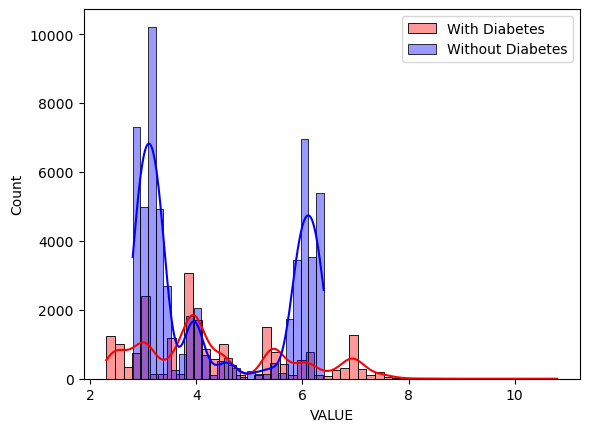

In [38]:
sns.histplot(hemoglobin_a1c_labeled.query('HASDIABETES == 1')['VALUE'].astype('float'), kde=True, label="With Diabetes", color="red", alpha=0.4)
sns.histplot(hemoglobin_a1c_labeled.query('HASDIABETES == 0')['VALUE'].astype('float'), kde=True, label="Without Diabetes", color="blue", alpha=0.4)
plt.legend()
plt.show()

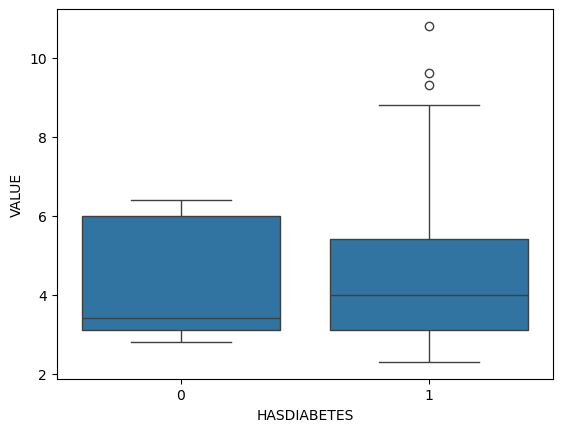

In [44]:
sns.boxplot(
    hemoglobin_a1c_labeled.astype({'VALUE': float}),
    x='HASDIABETES',
    y='VALUE'
)

plt.show()

In [50]:
hemoglobin_a1c_labeled.astype({'VALUE': 'float'}).groupby('HASDIABETES')['VALUE'].describe()

,count,mean,std,min,25%,50%,75%,max
HASDIABETES,,,,,,,,
0,59465.0,4.326014,1.393244,2.8,3.1,3.4,6.0,6.4
1,22029.0,4.371542,1.400557,2.3,3.1,4.0,5.4,10.8


If we want to quantify whether there is a significant difference in the two distributions \
one option is the use the Mann-Whitney U (Wilcoxon rank-sum) test \
provided by scipy's mannwhitneyu() function

In [45]:
from scipy.stats import mannwhitneyu

In [48]:
U1, p = mannwhitneyu(
    hemoglobin_a1c_labeled.query('HASDIABETES == 1')['VALUE'].astype('float'),
    hemoglobin_a1c_labeled.query('HASDIABETES == 0')['VALUE'].astype('float'), 
    method="auto"
)

In [49]:
print(f"U1: {U1}, p-value: {p}")

U1: 675766448.0, p-value: 2.971861319767635e-12


# Discussion Points
1. Why is it that we observe a bi-modal distribution in A1C values among patients without a Type 2 Diabetes diagnosis?
2. Why the right skew-ness and positive outliers in the distribution among the Type 2 diabetes positive patients?
3. How can we extend this analysis to add additional nuance (additional lab tests, adding data from other tables, partitioning patients further based on \
   other diagnoses, medications, demographics etc?

# 2. Extensions to Initial Analysis
Try to see if you can extend the initial analysis that we did on Hemoglobin A1C and diabetes

1. Are there any other labs that you could pull data for and compare distributions for between Type-2 and non-Type2 patients
2. Could you further subdivide the Type 2 and non-Type 2 patients into additional subsets based on other diagnoses/demographics/medication status?